In [70]:
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq

In [73]:
# specify the directory containing the CSV files
directory = "C:\\Users\\20203697\\Desktop\\DBL2_data\\bronze"

# initialize an empty list to store dataframes
df_list = []

# iterate through all subfolders and CSV files in the directory
for root, dirs, files in os.walk(directory):
    for filename in files:
        # print(filename)
        #Change csv names
        if filename.endswith("metropolitan-street.csv"): 
            # print(filename)
            # read the CSV file into a dataframe and append to the list
            filepath = os.path.join(root, filename)
            df = pd.read_csv(filepath)
            df_list.append(df)

# concatenate all dataframes into a single dataframe
concatenated_df = pd.concat(df_list, axis=0, ignore_index=True)
# write the concatenated dataframe to a new parquet file
output_filepath = "C:\\Users\\20203697\\Desktop\\DBL2_data\\silver\\Metropolitan-street.parquet"

# write the concatenated dataframe to a Parquet file
table = pa.Table.from_pandas(concatenated_df)
pq.write_table(table, output_filepath)

In [62]:
pip install fsspec


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\20203697\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [74]:
# Read the Parquet file into a pandas DataFrame
df = pd.read_parquet('C:\\Users\\20203697\\Desktop\\DBL2_data\\silver\\Metropolitan-street.parquet')

# Do something with the DataFrame
df.head()
data = df.where(df['Month'] == '2014-02')
data[~data.isnull().any(axis=1)]

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context


In [75]:
# Filter the DataFrame to only include rows where the LSOA name is 'Barnet' and the Crime type is 'Burglary'
filtered_df = df[(df['LSOA name'].str.contains('Barnet')) & (df['Crime type'].str.contains('Burglary'))]

filtered_df

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context
2051,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.201877,51.655538,On or near High Street,E01000248,Barnet 001A,Burglary,None,NaN
2052,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.207853,51.654317,On or near The Avenue,E01000248,Barnet 001A,Burglary,None,NaN
2053,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.202510,51.656348,On or near Bruce Road,E01000248,Barnet 001A,Burglary,None,NaN
2054,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.206779,51.654768,On or near The Drive,E01000248,Barnet 001A,Burglary,None,NaN
2071,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.209537,51.655223,On or near Marriott Road,E01000249,Barnet 001B,Burglary,None,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13079989,fda0870be993d2c9352ae14a540bf529c15a7aa9d92a4e...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.202163,51.559100,On or near Hocroft Road,E01000139,Barnet 041B,Burglary,Under investigation,NaN
13079990,c6c2d9a772695865f4ca33fce59c26c48fe3a1cdac8c22...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.202163,51.559100,On or near Hocroft Road,E01000139,Barnet 041B,Burglary,Under investigation,NaN
13080002,e5bab2bd4f31de44515dbf125b85284392d0349139a1d3...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.197843,51.561093,On or near Church Walk,E01000140,Barnet 041C,Burglary,Under investigation,NaN
13080003,823465427f8764e250a48312715a4bd87e8012412046c6...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.199449,51.563896,On or near Llanelly Road,E01000140,Barnet 041C,Burglary,Under investigation,NaN


In [65]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\20203697\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [77]:
import matplotlib.pyplot as plt
import calendar 
import numpy as np


In [78]:
# i want to get from the Month column of filtered_df the month and year and add two new columns named Month num and Year

# create a new column named Month num and extract the month number from the Month column
filtered_df['Month num'] = filtered_df['Month'].str[5:7]

# create a new column named Year and extract the year from the Month column
filtered_df['Year'] = filtered_df['Month'].str[0:4]

# convert the Month num and Year columns to numeric values
filtered_df['Month num'] = pd.to_numeric(filtered_df['Month num'])
filtered_df['Year'] = pd.to_numeric(filtered_df['Year'])

# sort the DataFrame by the Year and then Month num columns
# filtered_df = filtered_df.sort_values(by=['Year', 'Month num'])

# create a new column named Month name and convert the Month num column to the month name
#filtered_df['Month name'] = filtered_df['Month num'].apply(lambda x: calendar.month_abbr[x])

# delete the Year month column
#del filtered_df['Month']


# print the first 5 rows of the filtered DataFrame
filtered_df.head()


C:\Users\20203697\AppData\Local\Temp\ipykernel_6912\1985963670.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Month num'] = filtered_df['Month'].str[5:7]
C:\Users\20203697\AppData\Local\Temp\ipykernel_6912\1985963670.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['Year'] = filtered_df['Month'].str[0:4]
C:\Users\20203697\AppData\Local\Temp\ipykernel_6912\1985963670.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Crime type,Last outcome category,Context,Month num,Year
2051,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.201877,51.655538,On or near High Street,E01000248,Barnet 001A,Burglary,None,NaN,12,2010
2052,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.207853,51.654317,On or near The Avenue,E01000248,Barnet 001A,Burglary,None,NaN,12,2010
2053,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.202510,51.656348,On or near Bruce Road,E01000248,Barnet 001A,Burglary,None,NaN,12,2010
2054,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.206779,51.654768,On or near The Drive,E01000248,Barnet 001A,Burglary,None,NaN,12,2010
2071,None,2010-12,Metropolitan Police Service,Metropolitan Police Service,-0.209537,51.655223,On or near Marriott Road,E01000249,Barnet 001B,Burglary,None,NaN,12,2010


In [69]:
# write the concatenated dataframe to a new parquet file
output_filepath = "C:\\Users\\20203697\\Desktop\\DBL2_data\\cleaned\\Metropolitan-street.parquet"

# write the concatenated dataframe to a Parquet file
table = pa.Table.from_pandas(filtered_df)
pq.write_table(table, output_filepath)

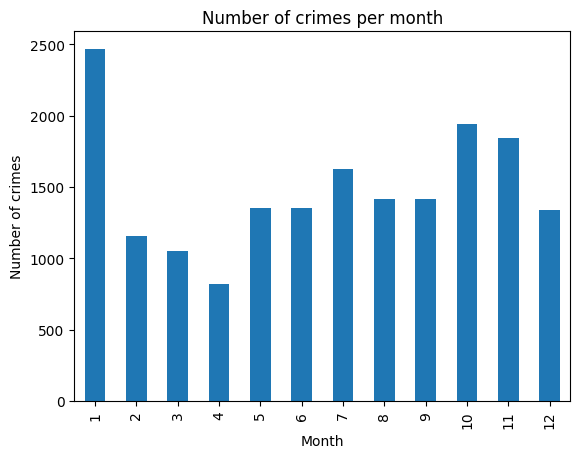

In [47]:
filtered_df.groupby('Month num')['Crime ID'].count().plot(kind='bar')

# set the title and axis labels
plt.title('Number of crimes per month')
plt.xlabel('Month')
plt.ylabel('Number of crimes')

# display the plot
plt.show()

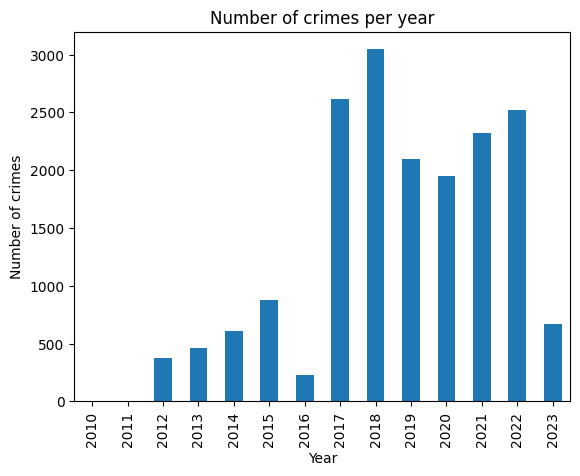

In [48]:
filtered_df.groupby('Year')['Crime ID'].count().plot(kind='bar')

# set the title and axis labels
plt.title('Number of crimes per year')
plt.xlabel('Year')
plt.ylabel('Number of crimes')

# display the plot
plt.show()

In [49]:
# initialize an empty list to store dataframes
df_list2 = []

# iterate through all subfolders and CSV files in the directory
for root, dirs, files in os.walk(directory):
    for filename in files:
        # print(filename)
        #Change csv names
        if filename.endswith("metropolitan-stop-and-search.csv"): 
            # print(filename)
            # read the CSV file into a dataframe and append to the list
            filepath = os.path.join(root, filename)
            df2 = pd.read_csv(filepath)
            df_list2.append(df2)

# concatenate all dataframes into a single dataframe
concatenated_df2 = pd.concat(df_list2, axis=0, ignore_index=True)
# write the concatenated dataframe to a new parquet file
output_filepath = "C://Users//20212397//Desktop//Y2Q4//DC2//Metropolitan-stop-and-search.parquet"

# write the concatenated dataframe to a Parquet file
table2 = pa.Table.from_pandas(concatenated_df2)
pq.write_table(table2, output_filepath)

concatenated_df2.head()

C:\Users\20203697\AppData\Local\Temp\ipykernel_6912\2888570186.py:17: FutureWarning: Behavior when concatenating bool-dtype and numeric-dtype arrays is deprecated; in a future version these will cast to object dtype (instead of coercing bools to numeric values). To retain the old behavior, explicitly cast bool-dtype arrays to numeric dtype.
  concatenated_df2 = pd.concat(df_list2, axis=0, ignore_index=True)


FileNotFoundError: [WinError 3] Failed to open local file 'C://Users//20212397//Desktop//Y2Q4//DC2//Metropolitan-stop-and-search.parquet'. Detail: [Windows error 3] The system cannot find the path specified.


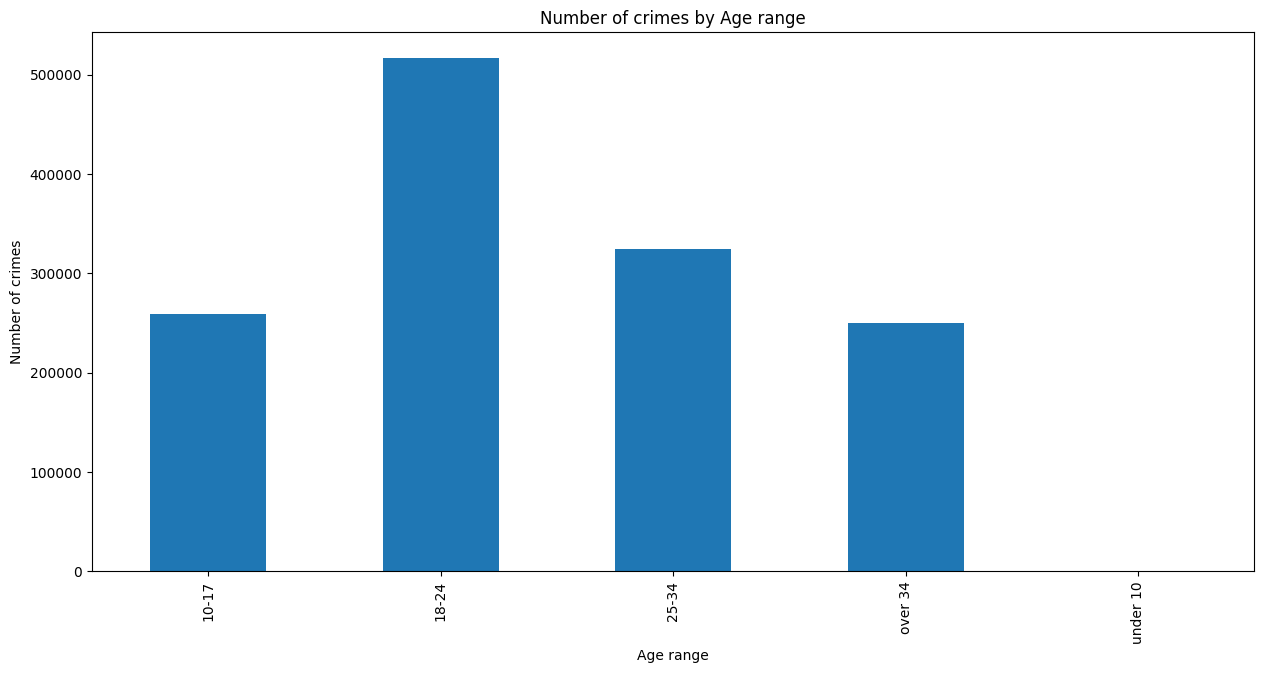

In [26]:
# plot the number of crimes by each Age range in a bar chart
fig, ax = plt.subplots(figsize=(15,7))
concatenated_df2.groupby(['Age range']).size().plot(ax=ax, kind='bar')
plt.title('Number of crimes by Age range')
plt.xlabel('Age range')
plt.ylabel('Number of crimes')
plt.show()
#

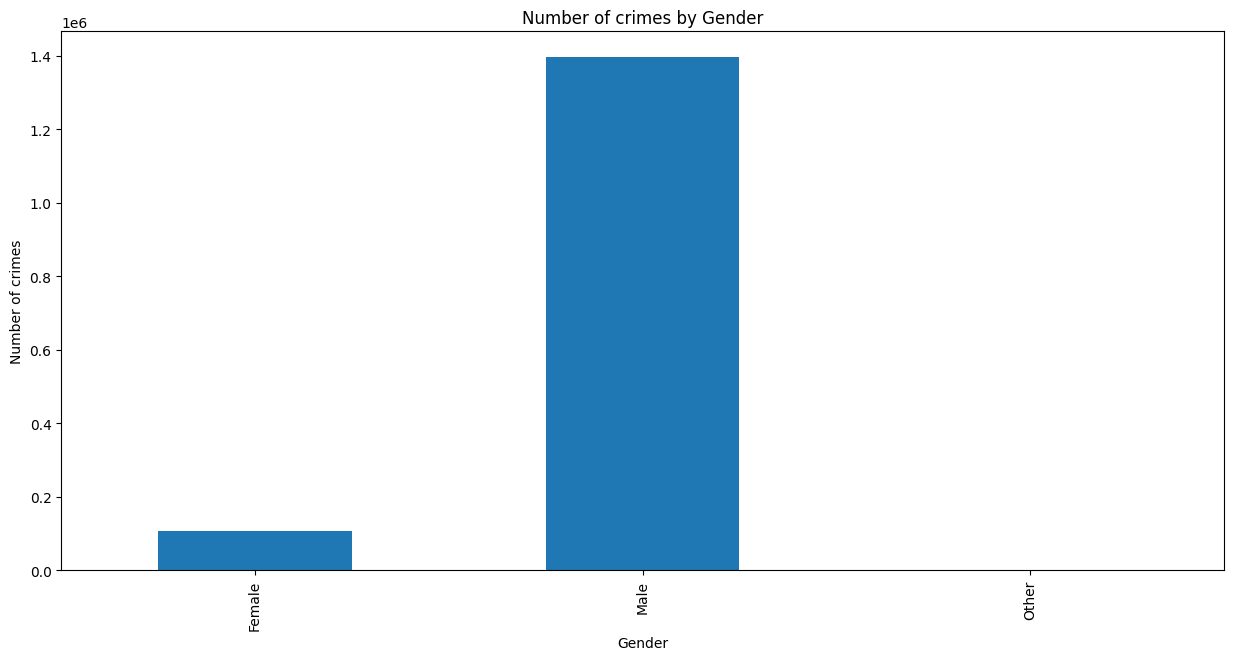

In [27]:
# plot the number of crimes per gender in a bar chart
fig, ax = plt.subplots(figsize=(15,7))
concatenated_df2.groupby(['Gender']).size().plot(ax=ax, kind='bar')
plt.title('Number of crimes by Gender')
plt.xlabel('Gender')
plt.ylabel('Number of crimes')
plt.show()

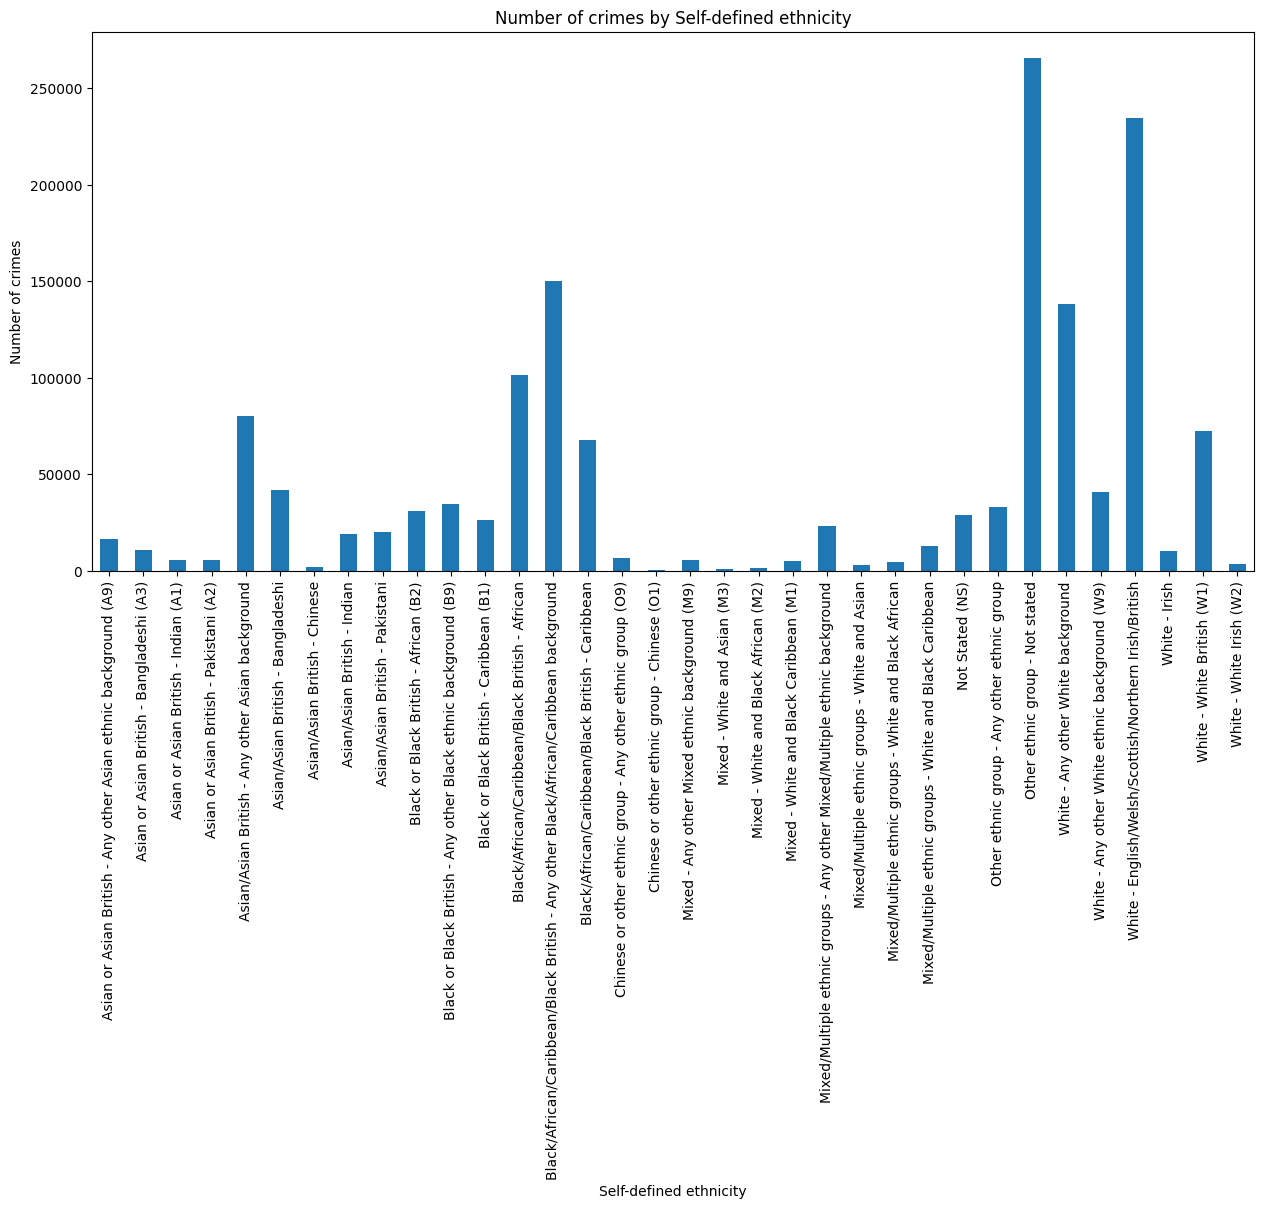

In [28]:
# plot the number of crimes by each Self-defined ethnicity in a bar chart
fig, ax = plt.subplots(figsize=(15,7))
concatenated_df2.groupby(['Self-defined ethnicity']).size().plot(ax=ax, kind='bar')
plt.title('Number of crimes by Self-defined ethnicity')
plt.xlabel('Self-defined ethnicity')
plt.ylabel('Number of crimes')
plt.show()

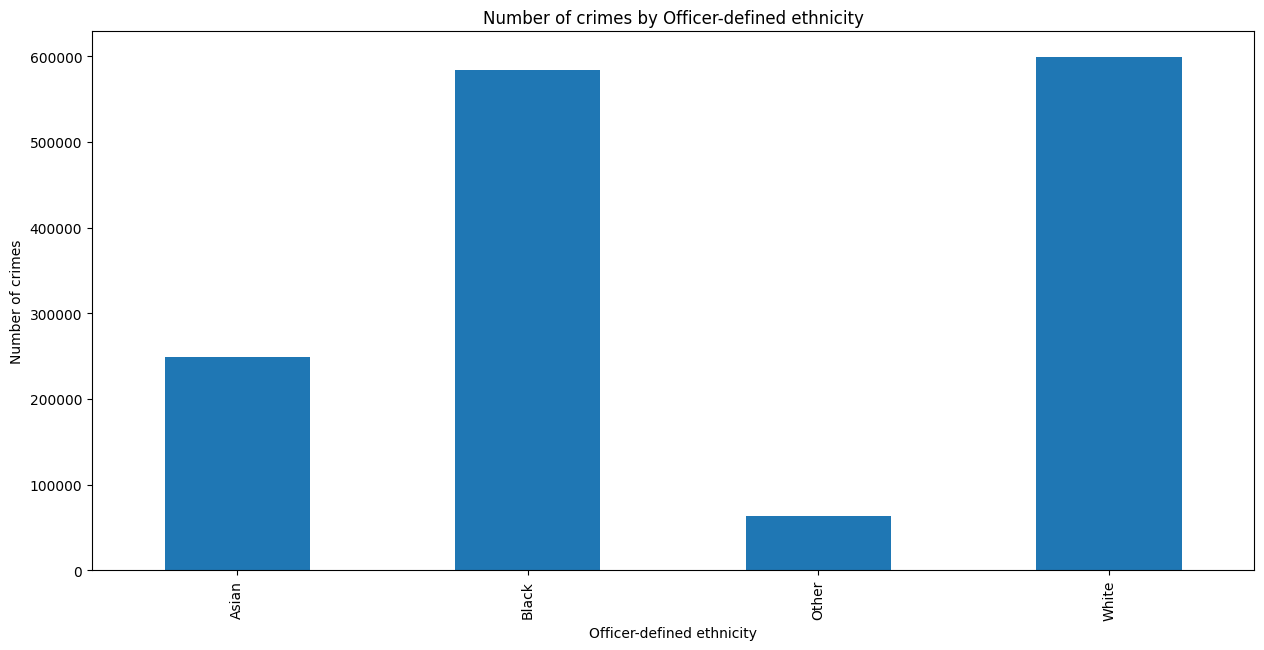

In [29]:
# plot the crimes by each Officer-defined ethnicity in a bar chart
fig, ax = plt.subplots(figsize=(15,7))
concatenated_df2.groupby(['Officer-defined ethnicity']).size().plot(ax=ax, kind='bar')
plt.title('Number of crimes by Officer-defined ethnicity')
plt.xlabel('Officer-defined ethnicity')
plt.ylabel('Number of crimes')
plt.show()

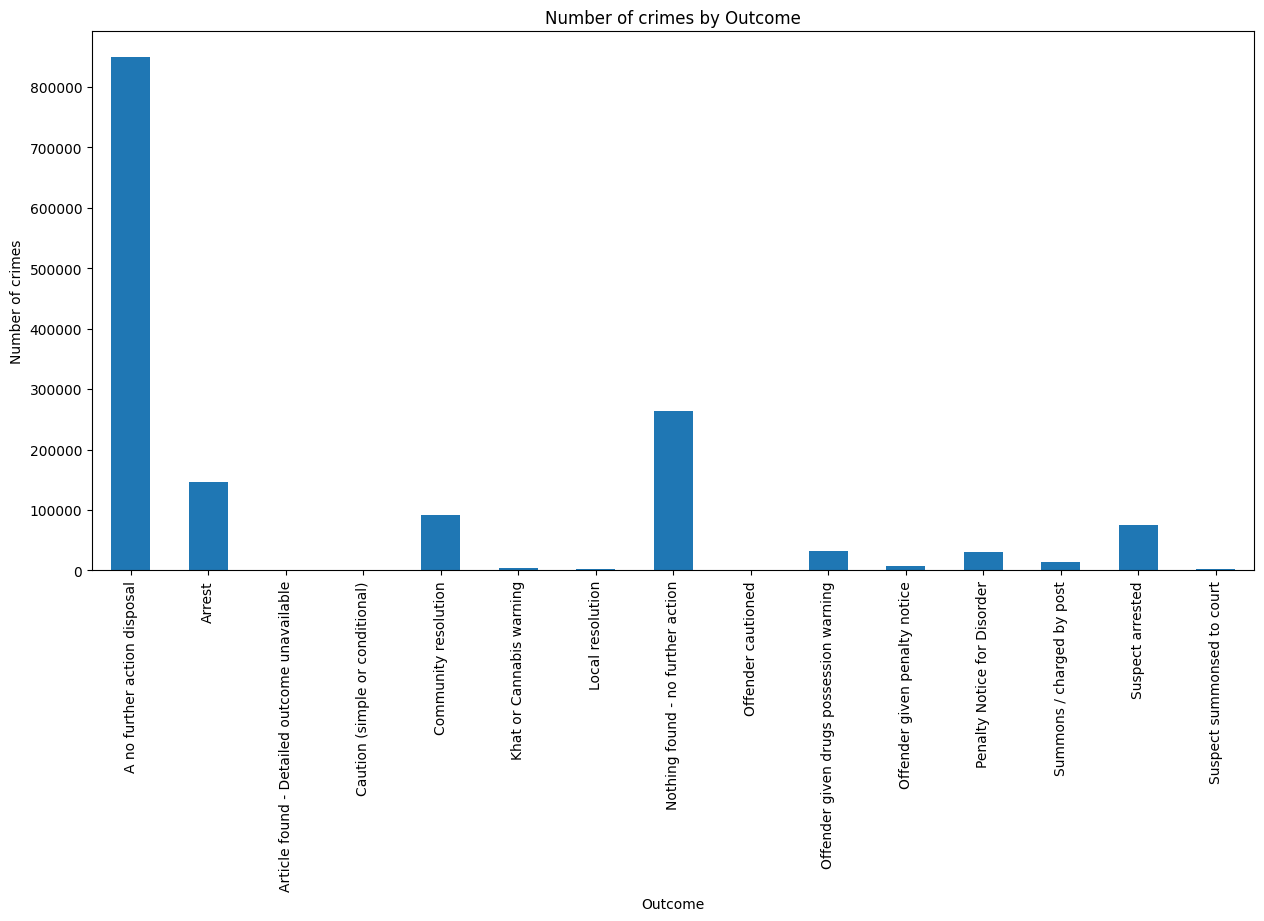

In [33]:
# plot the Outcome in a bar chart
fig, ax = plt.subplots(figsize=(15,7))
concatenated_df2.groupby(['Outcome']).size().plot(ax=ax, kind='bar')
plt.title('Number of crimes by Outcome')
plt.xlabel('Outcome')
plt.ylabel('Number of crimes')
plt.show()


In [31]:
# initialize an empty list to store dataframes
df_list3 = []

# iterate through all subfolders and CSV files in the directory
for root, dirs, files in os.walk(directory):
    for filename in files:
        # print(filename)
        #Change csv names
        if filename.endswith("metropolitan-outcomes.csv"): 
            # print(filename)
            # read the CSV file into a dataframe and append to the list
            filepath = os.path.join(root, filename)
            df3 = pd.read_csv(filepath)
            df_list3.append(df3)

# concatenate all dataframes into a single dataframe
concatenated_df3 = pd.concat(df_list3, axis=0, ignore_index=True)
# write the concatenated dataframe to a new parquet file
output_filepath = "C://Users//20212397//Desktop//Y2Q4//DC2//Metropolitan-outcomes.parquet"

# write the concatenated dataframe to a Parquet file
table3 = pa.Table.from_pandas(concatenated_df3)
pq.write_table(table3, output_filepath)

In [32]:
# Filter the DataFrame to only include rows where the LSOA name is 'Barnet'
filtered_df3 = df3[df3['LSOA name'].str.contains('Barnet') == True]

# Do something with the filtered DataFrame
filtered_df3.head()

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Outcome type
259,e73755559741d7251e0819e9e29b98b400dcf6365ab1fe...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.256798,51.639353,On or near,E01000228,Barnet 007A,Investigation complete; no suspect identified
368,1ff548bd410402370a3d7de9d1ade30f0250c2989b6d5e...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.202006,51.598547,On or near FRESTON PARK,E01000200,Barnet 028B,Investigation complete; no suspect identified
689,0d22d58852e291bcf6c99a63963f02dc9de2d0692931fd...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.159526,51.612143,On or near,E01000162,Barnet 015E,Suspect charged
1182,181fff2d5861d20ed728e9f6ba033f32978433285935b7...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.214148,51.650727,On or near,E01000294,Barnet 004F,Investigation complete; no suspect identified
1230,f9bee37a68797be96f89f78acae46225eb5a1b32873de9...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.151616,51.620911,On or near Link Road,E01000158,Barnet 015A,Investigation complete; no suspect identified


In [33]:
# i want to get from the Month column of filtered_df the month and year and add two new columns named Month num and Year

# create a new column named Month num and extract the month number from the Month column
filtered_df3['Month num'] = filtered_df3['Month'].str[5:7]

# create a new column named Year and extract the year from the Month column
filtered_df3['Year'] = filtered_df3['Month'].str[0:4]

# convert the Month num and Year columns to numeric values
filtered_df3['Month num'] = pd.to_numeric(filtered_df3['Month num'])
filtered_df3['Year'] = pd.to_numeric(filtered_df3['Year'])

# sort the DataFrame by the Year and then Month num columns
# filtered_df = filtered_df.sort_values(by=['Year', 'Month num'])

# create a new column named Month name and convert the Month num column to the month name
filtered_df3['Month name'] = filtered_df3['Month num'].apply(lambda x: calendar.month_abbr[x])

# delete the Year month column
# del filtered_df3['Year month']


# print the first 5 rows of the filtered DataFrame
filtered_df3.head()

C:\Users\20212397\AppData\Local\Temp\ipykernel_19256\1447476470.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df3['Month num'] = filtered_df3['Month'].str[5:7]
C:\Users\20212397\AppData\Local\Temp\ipykernel_19256\1447476470.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df3['Year'] = filtered_df3['Month'].str[0:4]
C:\Users\20212397\AppData\Local\Temp\ipykernel_19256\1447476470.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

,Crime ID,Month,Reported by,Falls within,Longitude,Latitude,Location,LSOA code,LSOA name,Outcome type,Month num,Year,Month name
259,e73755559741d7251e0819e9e29b98b400dcf6365ab1fe...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.256798,51.639353,On or near,E01000228,Barnet 007A,Investigation complete; no suspect identified,3,2023,Mar
368,1ff548bd410402370a3d7de9d1ade30f0250c2989b6d5e...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.202006,51.598547,On or near FRESTON PARK,E01000200,Barnet 028B,Investigation complete; no suspect identified,3,2023,Mar
689,0d22d58852e291bcf6c99a63963f02dc9de2d0692931fd...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.159526,51.612143,On or near,E01000162,Barnet 015E,Suspect charged,3,2023,Mar
1182,181fff2d5861d20ed728e9f6ba033f32978433285935b7...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.214148,51.650727,On or near,E01000294,Barnet 004F,Investigation complete; no suspect identified,3,2023,Mar
1230,f9bee37a68797be96f89f78acae46225eb5a1b32873de9...,2023-03,Metropolitan Police Service,Metropolitan Police Service,-0.151616,51.620911,On or near Link Road,E01000158,Barnet 015A,Investigation complete; no suspect identified,3,2023,Mar


In [11]:
pip install requests

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\20212397\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [58]:
import requests

In [59]:
locations = [
    "High Barnet",
    "Underhill",
    "Barnet Vale",
    "East Barnet",
    "Friern Barnet",
    "Woodhouse",
    "Whetstone",
    "Brunswick Park",
    "Totteridge and Woodside",
    "Mill Hill",
    "Cricklewood",
    "Edgwarebury",
    "Burnt Oak",
    "Edgware",
    "Colindale South",
    "West Hendon",
    "Colindale North",
    "Hendon",
    "West Finchley",
    "East Finchley",
    "Garden Suburb",
    "Finchley Church End",
    "Golders Green",
    "Childs Hill"
]

In [60]:
response = requests.get("https://data.police.uk/api/metropolitan/neighbourhoods")
print(response.status_code)

200


In [61]:
print(response.json())

[{'id': 'E05009317', 'name': 'Bethnal Green East'}, {'id': 'E05009318', 'name': 'Blackwall and Cubitt Town'}, {'id': 'E05009319', 'name': 'Bow East'}, {'id': 'E05009320', 'name': 'Bow West'}, {'id': 'E05009321', 'name': 'Bromley North'}, {'id': 'E05009322', 'name': 'Bromley South'}, {'id': 'E05009323', 'name': 'Canary Wharf'}, {'id': 'E05009324', 'name': 'Island Gardens'}, {'id': 'E05009325', 'name': 'Lansbury'}, {'id': 'E05009326', 'name': 'Limehouse'}, {'id': 'E05009327', 'name': 'Mile End'}, {'id': 'E05009328', 'name': 'Poplar'}, {'id': 'E05009329', 'name': "St Dunstan's"}, {'id': 'E05009330', 'name': "St Katharine's and Wapping"}, {'id': 'E05009331', 'name': 'Bethnal Green West'}, {'id': 'E05009332', 'name': 'Shadwell'}, {'id': 'E05009333', 'name': 'Spitalfields and Banglatown'}, {'id': 'E05009334', 'name': 'Stepney Green'}, {'id': 'E05009335', 'name': 'Weavers'}, {'id': 'E05009336', 'name': 'Whitechapel'}, {'id': 'E05009367', 'name': 'Brownswood'}, {'id': 'E05009368', 'name': 'Caz

In [63]:
barnet_ids = []

for d in response.json():
    if d['name'] in locations:
        barnet_ids.append(d["id"])

In [64]:
print(barnet_ids)
len(barnet_ids)

['E05013545', 'E05013628', 'E05013629', 'E05013630', 'E05013631', 'E05013632', 'E05013633', 'E05013634', 'E05013635', 'E05013636', 'E05013637', 'E05013638', 'E05013639', 'E05013640', 'E05013641', 'E05013642', 'E05013643', 'E05013644', 'E05013645', 'E05013646', 'E05013647', 'E05013648', 'E05013649', 'E05013650', 'E05013651']


25

In [65]:
import requests
import pandas as pd

In [66]:
# create a dataframe with the id and name of each neighbourhood
# in the Barnet borough. Set id as the index.
response = requests.get("https://data.police.uk/api/metropolitan/neighbourhoods")
barnet_df = pd.DataFrame(response.json())
barnet_df = barnet_df[barnet_df['name'].isin(locations)]
barnet_df = barnet_df.set_index('id')
barnet_df.head()

,name
id,
E05013545,Edgware
E05013628,Barnet Vale
E05013629,Brunswick Park
E05013630,Burnt Oak
E05013631,Childs Hill


In [67]:
def get_bound(x):
    bound = requests.get(f"https://data.police.uk/api/metropolitan/{x}/boundary").json()
    bound = [(d["latitude"], d["longitude"]) for d in bound]
    return bound

barnet_df['boundaries'] = barnet_df.apply(lambda x: get_bound(x.name), axis=1)

barnet_df.head()

,name,boundaries
id,,
E05013545,Edgware,"[(51.612277994295, -0.28101069219112), (51.611..."
E05013628,Barnet Vale,"[(51.634276016337, -0.17977180627771), (51.634..."
E05013629,Brunswick Park,"[(51.627511902482, -0.15625171052302), (51.627..."
E05013630,Burnt Oak,"[(51.597724278003, -0.25291781885811), (51.597..."
E05013631,Childs Hill,"[(51.559882977663, -0.19691984536718), (51.559..."


In [68]:
import folium

In [69]:
def add_wards_to_map(x):
    folium.Polygon(locations=x, color='black', fill=True, fill_color='black').add_to(m)

barnet_df['boundaries'].apply(add_wards_to_map)

: 

: 

In [17]:
pip install plotly

     ---------------------------------------- 0.0/15.3 MB ? eta -:--:--
      --------------------------------------- 0.3/15.3 MB 10.9 MB/s eta 0:00:02
     -- ------------------------------------- 1.0/15.3 MB 10.5 MB/s eta 0:00:02
     --- ------------------------------------ 1.4/15.3 MB 10.2 MB/s eta 0:00:02
     ----- ---------------------------------- 2.0/15.3 MB 10.5 MB/s eta 0:00:02
     ------ --------------------------------- 2.4/15.3 MB 10.2 MB/s eta 0:00:02
     ------- -------------------------------- 2.9/15.3 MB 10.3 MB/s eta 0:00:02
     -------- ------------------------------- 3.4/15.3 MB 10.4 MB/s eta 0:00:02
     ---------- ----------------------------- 3.9/15.3 MB 10.2 MB/s eta 0:00:02
     ----------- ---------------------------- 4.3/15.3 MB 10.1 MB/s eta 0:00:02
     ------------ --------------------------- 4.8/15.3 MB 10.2 MB/s eta 0:00:02
     ------------- -------------------------- 5.3/15.3 MB 10.2 MB/s eta 0:00:01
     --------------- ------------------------ 5.


[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: C:\Users\20212397\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [19]:
import plotly.express as px
from shapely.geometry import Polygon


In [1]:
print('hello')

hello


In [ ]:
# plot the boundaries of the neighbourhoods in the Barnet borough
import folium

# create a map of the Barnet borough
m = folium.Map(location=[51.6, -0.2], zoom_start=11)

# add each neighbourhood to the map
for row in barnet_df["boundaries"]:
    folium.Polygon(locations=row, color='blue').add_to(m)

# show the map
display(m)